In [7]:
import time
start_time = time.time()

# 1st Test

In [8]:
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [9]:
# Garantir consistência para reproducibilidade
np.random.seed(42)

# Função para DWT e geração de lags
def dwt_transform(data, wavelet='db4', level=2):
    """Extrai componente de tendência usando DWT."""
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs[0]  # Tendência

def create_lags(data, n_lags=24):
    """Cria lags temporais para séries temporais."""
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])  # Janela de entrada
        y.append(data[i])           # Valor alvo
    return np.array(X), np.array(y)

In [10]:
df = pd.read_csv('../../dataset2001_2024.csv')
df.tail()

,YEAR,MO,DY,HR,ALLSKY_SFC_UV_INDEX,ALLSKY_SRF_ALB,CLRSKY_KT,CLOUD_AMT,T2M,PS,PW,WD10M,WD50M,WS50M,WS10M,TOA_SW_DNI,QV2M,QV10M
201595,2023,12,31,19,2.92,0.15,0.67,31.79,28.00,93.33,2.72,155.45,154.80,6.44,5.66,1408.66,11.47,11.29
201596,2023,12,31,20,0.80,0.13,0.58,20.45,25.87,93.38,2.70,152.49,152.07,7.36,6.12,1408.61,11.72,11.66
201597,2023,12,31,21,0.05,0.16,0.38,31.40,23.62,93.45,2.70,148.69,148.45,7.88,6.21,1408.76,12.08,12.02
201598,2023,12,31,22,0.00,-999.00,-999.00,21.06,21.87,93.52,2.71,145.60,145.61,7.41,5.61,0.00,12.45,12.39
201599,2023,12,31,23,0.00,-999.00,-999.00,22.94,20.82,93.55,2.72,140.66,140.22,6.68,4.93,0.00,12.70,12.70


In [11]:
# Filtrar dados apenas até 2022
df_filtered = df[df['YEAR'] < 2023]
t2m_data = df_filtered['T2M'].values

# Aplicar DWT para extrair tendência
trend_component = dwt_transform(t2m_data)

# Criar lags temporais com janela de 24 horas
n_lags = 24
X, y = create_lags(trend_component, n_lags=n_lags)

# Escalar os dados
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Ajustar a entrada para o formato (samples, timesteps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [12]:
# Separar treino e teste (80% treino)
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [13]:
# Criar o modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_lags, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True), 
    Dropout(0.2),
    LSTM(16),  
    Dropout(0.2),
    Dense(64, activation='relu'), 
    Dense(1)  
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    #callbacks=[early_stop]
)

# Fazer previsões
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Converter os valores reais para a escala original
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/100


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0241 - mae: 0.1183 - val_loss: 0.0113 - val_mae: 0.0855
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0084 - mae: 0.0721 - val_loss: 0.0095 - val_mae: 0.0761
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0052 - mae: 0.0552 - val_loss: 0.0055 - val_mae: 0.0580
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0040 - mae: 0.0481 - val_loss: 0.0039 - val_mae: 0.0472
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0031 - mae: 0.0421 - val_loss: 0.0033 - val_mae: 0.0428
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0030 - mae: 0.0412 - val_loss: 0.0043 - val_mae: 0.0505
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0027 - mae: 0.0389 - val_loss: 0.0047 - val_mae: 0.0527
Epoch 8/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0022 - mae: 0.0359 - val_loss: 0.0027 - val_mae: 0.0393
Epoch 9/100
1205/1205 ━━━━━━━━

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Preparação dos dados (X e y já preparados anteriormente com os lags)
# Garantir que os dados ainda estão disponíveis
X_rf_train, X_rf_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
y_rf_train, y_rf_test = y_train, y_test

# Treinamento do Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf_train, y_rf_train.ravel())

# Previsões
rf_predictions_scaled = rf_model.predict(X_rf_test)
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1))
y_rf_test_real = scaler_y.inverse_transform(y_rf_test.reshape(-1, 1))

# Avaliação do modelo
mae_rf = mean_absolute_error(y_rf_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_rf_test_real, rf_predictions))

print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")


Random Forest - MAE: 1.6359, RMSE: 2.3378


## Comparison between RF and LSTM

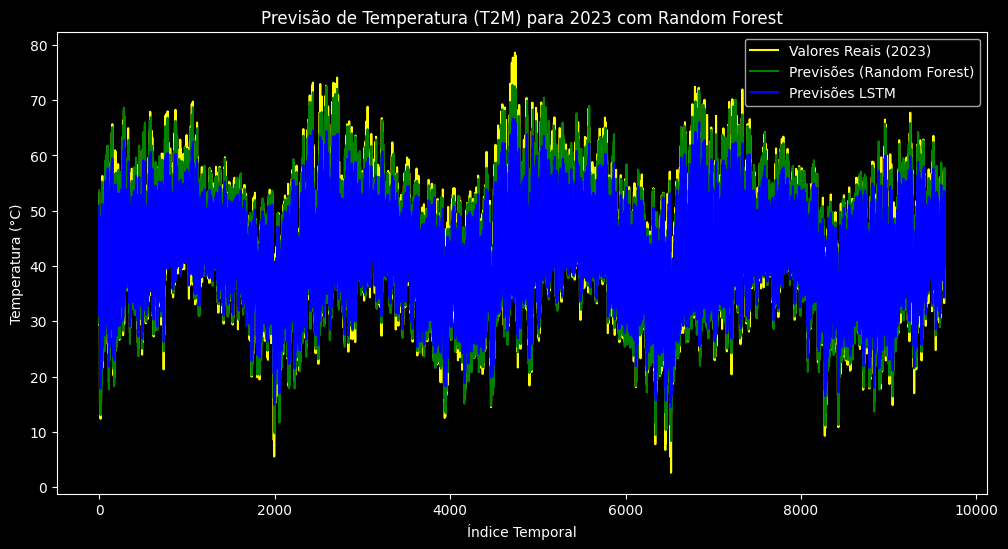

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_rf_test_real, label='Valores Reais (2023)', color='yellow')
plt.plot(rf_predictions, label='Previsões (Random Forest)', color='green')
plt.plot(predictions, label='Previsões LSTM', color='blue')
plt.title('Previsão de Temperatura (T2M) para 2023 com Random Forest')
plt.xlabel('Índice Temporal')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

In [16]:
mae_lstm = mean_absolute_error(y_test_real, predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, predictions))
mae_rf = mean_absolute_error(y_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, rf_predictions))

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

LSTM - MAE: 2.3064, RMSE: 3.0076
Random Forest - MAE: 1.6359, RMSE: 2.3378


# 2nd - Improving LSTM and RF

Epoch 1/100


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0204 - val_loss: 0.0143
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0111 - val_loss: 0.0076
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 11/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/100
603/603 ━━━━━━━━━━━━

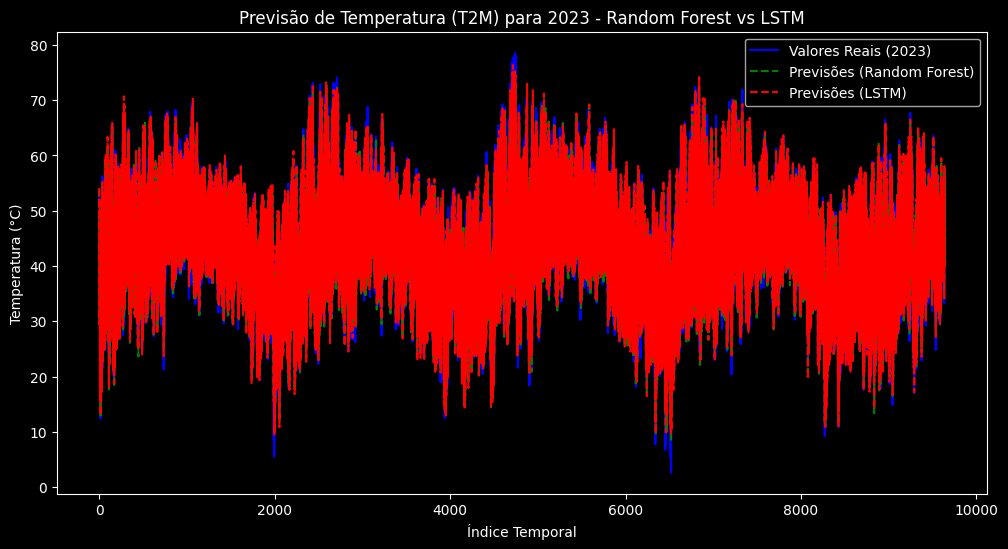

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Certifique-se de que os dados X_train, X_test, y_train, y_test já estão preparados.
# Normalização assumida como anteriormente configurada.

# Reconstruir o modelo LSTM com melhorias
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compilação com otimizador ajustado
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Treinamento com Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64, 
                               validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Previsões do modelo LSTM
lstm_predictions_scaled = model_lstm.predict(X_test)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled.reshape(-1, 1))

# Invertendo a escala dos valores reais
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Treinamento do Random Forest com parâmetros ajustados
rf_model = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

# Previsões do Random Forest
rf_predictions_scaled = rf_model.predict(X_test.reshape(X_test.shape[0], -1))
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1))

# Cálculo das métricas
mae_lstm = mean_absolute_error(y_test_real, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, lstm_predictions))
mae_rf = mean_absolute_error(y_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, rf_predictions))

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

# Plot comparativo
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Valores Reais (2023)', color='blue')
plt.plot(rf_predictions, label='Previsões (Random Forest)', color='green', linestyle='dashed')
plt.plot(lstm_predictions, label='Previsões (LSTM)', color='red', linestyle='dashed')
plt.title('Previsão de Temperatura (T2M) para 2023 - Random Forest vs LSTM')
plt.xlabel('Índice Temporal')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


# 3rd - Using Autoencoder to perform SSL

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

# Parâmetros da série temporal
timesteps = X_train.shape[1]
features = X_train.shape[2]

# Definição do autoencoder
input_seq = Input(shape=(timesteps, features))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(input_seq)
encoded_output = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded_output)
decoded_output = TimeDistributed(Dense(features))(decoded)

# Construção do modelo autoencoder
autoencoder = Model(inputs=input_seq, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Treinamento Self-Supervised
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))


Epoch 1/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0272 - val_loss: 0.0129
Epoch 2/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0108 - val_loss: 0.0042
Epoch 3/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 9.5176e-04 - val_loss: 9.3677e-04
Epoch 6/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 7.6697e-04 - val_loss: 7.3711e-04
Epoch 7/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.7962e-04 - val_loss: 6.7884e-04
Epoch 8/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.2753e-04 - val_loss: 6.6970e-04
Epoch 9/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.0166e-04 - val_loss: 6.1493e-04
Epoch 10/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5.5488e-04 - val_loss: 5.6562e-04
Epoch 11/20
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5.0036e

In [19]:
# Extraindo o encoder do autoencoder
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# Construindo o modelo supervisionado com os pesos treinados
from tensorflow.keras.models import Sequential

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

# Transferir pesos do encoder para a primeira camada LSTM do novo modelo
model_lstm.layers[0].set_weights(encoder_model.get_weights())
model_lstm.layers[0].trainable = False  # Congelando os pesos

# Compilar e treinar o modelo supervisionado
model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento supervisionado
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0188 - val_loss: 0.0115
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 9/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 10/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 11/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 12/50
1205/1205 ━━━━━━━━━━━━━━━━━━━

Epoch 1/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0166
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0014
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0011
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0010
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.3071e-04
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.0121e-04
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 8.7460e-04
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 8.6411e-04
Epoch 9/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 8.1521e-04
Epoch 10/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.7754e-04
Epoch 11/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.7860e-04
Epoch 12/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.7485e-04
Epoch 13/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.6025e-04
Epoch 14/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 

c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 0.0081 - val_loss: 7.1198e-04
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - loss: 6.2979e-04 - val_loss: 6.8222e-04
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - loss: 6.1462e-04 - val_loss: 6.6805e-04
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - loss: 6.1310e-04 - val_loss: 7.3824e-04
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - loss: 6.1674e-04 - val_loss: 7.0486e-04
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 6.1488e-04 - val_loss: 6.7680e-04
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 6.1214e-04 - val_loss: 7.0116e-04
Epoch 8/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - loss: 6.0463e-04 - val_loss: 6.6321e-04
Epoch 9/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 6.0773e-04 - val_loss: 7.2850e-04
Epoch 10/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 5.9917e-04 - val_loss: 6.8869e-04
Epoch 11/50
1205/1205 ━━━━━━━━━━━━

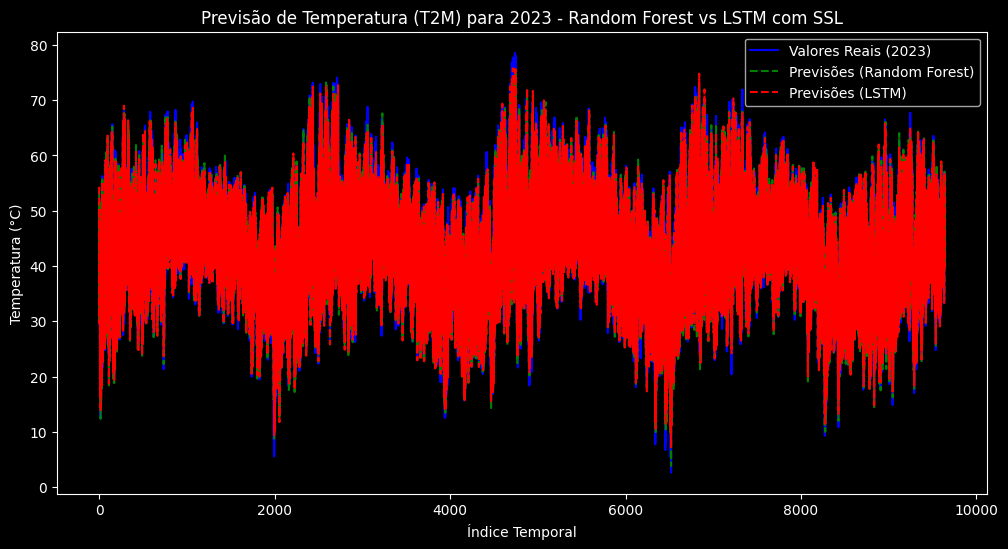

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Certifique-se de que os dados X_train, X_test, y_train, y_test já estão preparados.
# Normalização assumida como anteriormente configurada.

# Verificação de dimensões compatíveis
assert X_train.shape[0] == y_train.shape[0], "Tamanhos incompatíveis entre X_train e y_train"
assert X_test.shape[0] == y_test.shape[0], "Tamanhos incompatíveis entre X_test e y_test"

# Autoencoder com LSTM para Self-Supervised Learning
encoding_dim = 32

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoded = LSTM(64, return_sequences=False)(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(X_train.shape[2], activation='linear')(encoded)

# Construção do autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compilação do autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Treinamento do autoencoder
early_stopping_ae = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping_ae], verbose=1)

# Codificação dos dados de treino e teste
X_encoded_train = encoder.predict(X_train)
X_encoded_test = encoder.predict(X_test)

# Reconstrução do modelo LSTM supervisionado com pesos do encoder
model_lstm = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compilação
model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento com Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history_lstm = model_lstm.fit(X_encoded_train, y_train, epochs=50, batch_size=32, 
                               validation_data=(X_encoded_test, y_test), callbacks=[early_stopping], verbose=1)

# Previsões do modelo LSTM
lstm_predictions_scaled = model_lstm.predict(X_encoded_test)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled.reshape(-1, 1))

# Invertendo a escala dos valores reais
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Treinamento do Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_encoded_train, y_train.ravel())

# Previsões do Random Forest
rf_predictions_scaled = rf_model.predict(X_encoded_test)
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1))

# Cálculo das métricas
mae_lstm = mean_absolute_error(y_test_real, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, lstm_predictions))
mae_rf = mean_absolute_error(y_test_real, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, rf_predictions))

print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

# Plot comparativo
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Valores Reais (2023)', color='blue')
plt.plot(rf_predictions, label='Previsões (Random Forest)', color='green', linestyle='dashed')
plt.plot(lstm_predictions, label='Previsões (LSTM)', color='red', linestyle='dashed')
plt.title('Previsão de Temperatura (T2M) para 2023 - Random Forest vs LSTM com SSL')
plt.xlabel('Índice Temporal')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()



In [21]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo total de execução: {execution_time:.4f} segundos")

Tempo total de execução: 2764.2241 segundos


> Tempo total de execução: 2764.2241 segundos